In [1]:
import matplotlib.pyplot as plt
import metadata
import midi
import numpy as np
import pandas as pd
import pathlib
import similarity
import util

{'dataset_root': '../../sabana/dataset/asap-dataset', 'frame_per_second': 20, 'slice_duration': 5.0, 'expansion_rate': 1.5, 'settling_frame': 10, 'compensation_frame': 0, 'use_subsequence_dtw': True, 'use_decay_for_histogram': True}
# of pos_*.npz files: 100
# of neg_*.npz files: 92


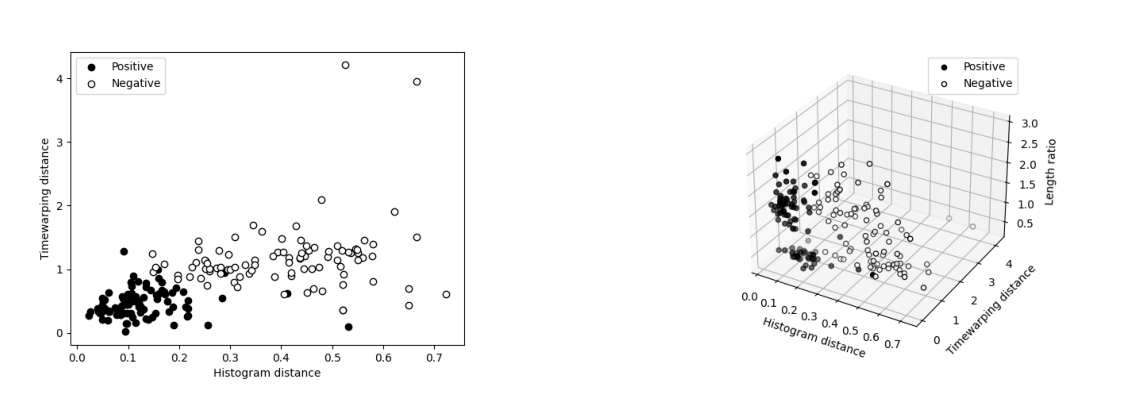

<Figure size 432x288 with 0 Axes>

In [2]:
save_root = "./save_asap"
save_root = pathlib.Path(save_root)
if not save_root.exists():
    raise FileExistsError(save_root)
elif not save_root.is_dir():
    raise FileExistsError(save_root)

config_path = save_root / "config.json"
if not config_path.exists():
    raise FileExistsError(config_path)
elif not config_path.is_file():
    raise FileExistsError(config_path)
config = metadata.Metadata.load(filepath=config_path)
print(config.get_config())

scatter_2d_path = save_root / "scatter_2d.png"
if not scatter_2d_path.exists():
    raise FileExistsError(scatter_2d_path)
elif not scatter_2d_path.is_file():
    raise FileExistsError(scatter_2d_path)

scatter_3d_path = save_root / "scatter_3d.png"
if not scatter_3d_path.exists():
    raise FileExistsError(scatter_3d_path)
elif not scatter_3d_path.is_file():
    raise FileExistsError(scatter_3d_path)

pos_csv_path = save_root / "pos.csv"
if not pos_csv_path.exists():
    raise FileExistsError(pos_csv_path)
elif not pos_csv_path.is_file():
    raise FileExistsError(pos_csv_path)
pos_csv = pd.read_csv(pos_csv_path)

neg_csv_path = save_root / "neg.csv"
if not neg_csv_path.exists():
    raise FileExistsError(neg_csv_path)
elif not neg_csv_path.is_file():
    raise FileExistsError(neg_csv_path)
neg_csv = pd.read_csv(neg_csv_path)

npz_root = save_root / "npz"
if not npz_root.exists():
    raise FileExistsError(npz_root)
elif not npz_root.is_dir():
    raise FileExistsError(npz_root)
pos_npz_paths = list(npz_root.glob("*pos*"))
neg_npz_paths = list(npz_root.glob("*neg*"))

num_pos_npz = len(pos_npz_paths)
num_neg_npz = len(neg_npz_paths)

print(f"# of pos_*.npz files: {num_pos_npz}")
print(f"# of neg_*.npz files: {num_neg_npz}")

fig, ax = plt.subplots(1,2, figsize=(20, 10))
ax[0].axis("off")
ax[0].imshow(plt.imread(scatter_2d_path))
ax[1].axis("off")
ax[1].imshow(plt.imread(scatter_3d_path))
plt.show()
plt.clf()

In [10]:
histogram_min, histogram_max = (0, 0.1)
timewarping_min, timewarping_max = (0, 10)

In [11]:
selected_pos_indices = pos_csv.index[pos_csv["Histogram distance"] <= histogram_max].tolist()
print(len(selected_pos_indices))

43


['score', 'perf', 'alignment']


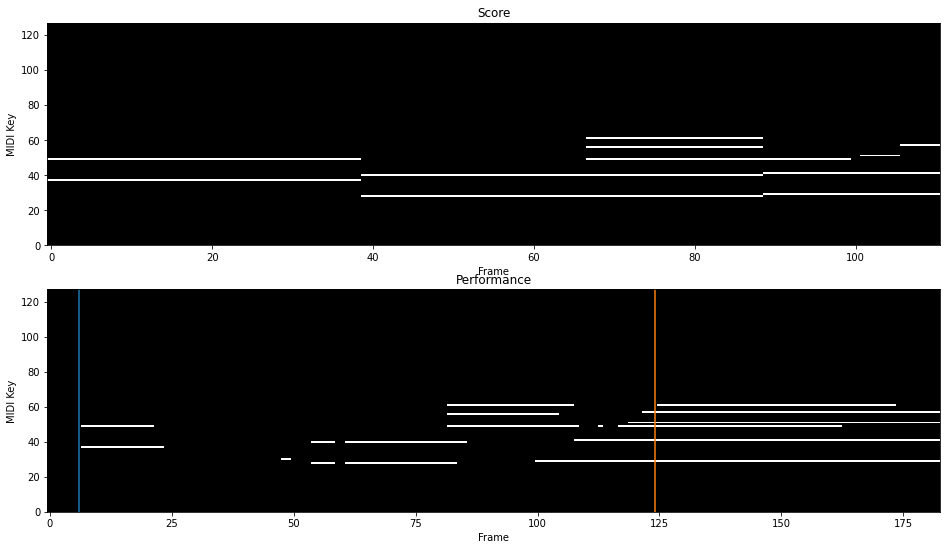

<Figure size 432x288 with 0 Axes>

In [12]:
for selected_pos_index in selected_pos_indices[:1]:
    selected_pos_npz_path = pos_npz_paths[selected_pos_index]
    with np.load(selected_pos_npz_path, allow_pickle=True) as selected_pos_npz_file:
        print(selected_pos_npz_file.files)
        score = selected_pos_npz_file["score"]
        perf = selected_pos_npz_file["perf"]
        head, tail = selected_pos_npz_file["alignment"]
        util.plot_midi_matrices(score, perf, head, tail)

In [13]:
score_unit_seq_list = midi.MIDIUnitSequenceList.from_midi_matrix(score, settling_frame=10)
perf_unit_seq_list = midi.MIDIUnitSequenceList.from_midi_matrix(perf, settling_frame=10)

score_sequence = score_unit_seq_list.to_representative_unit_sequence(config.compensation_frame)
perf_sequence = perf_unit_seq_list.to_representative_unit_sequence(config.compensation_frame)


if config.use_subsequence_dtw:
    timewarping_distance, (head, tail), _ = similarity.algorithm.subsequence_dtw(score_sequence, perf_sequence)

    if config.use_decay_for_histogram:
        score_histogram = score_unit_seq_list.to_pitch_histogram(with_decay=True)
        perf_histogram = perf_unit_seq_list[head : tail + 1].to_pitch_histogram(with_decay=True)
    else:
        score_histogram = score_unit_seq_list.to_pitch_histogram(with_decay=False)
        perf_histogram = perf_unit_seq_list[head : tail + 1].to_pitch_histogram(with_decay=False)

else:
    timewarping_distance = similarity.algorithm.levenshtein(score_sequence, perf_sequence, stabilize=True)

    if config.use_decay_for_histogram:
        score_histogram = score_unit_seq_list.to_pitch_histogram(with_decay=True)
        perf_histogram = perf_unit_seq_list.to_pitch_histogram(with_decay=True)
    else:
        score_histogram = score_unit_seq_list.to_pitch_histogram(with_decay=False)
        perf_histogram = perf_unit_seq_list.to_pitch_histogram(with_decay=False)

histogram_distance = similarity.algorithm.euclidean(score_histogram, perf_histogram)

print(f"Histogram distance: {histogram_distance}, Timewarping distance: {timewarping_distance}")

Histogram distance: 0.09817412495613098, Timewarping distance: 0.14039950033804194


In [14]:
print(f"Score histogram: {score_histogram}")
print(f"Perf histogram: {perf_histogram}")

Score histogram: [0.         0.37894738 0.         0.07368421 0.18947369 0.18947369
 0.         0.         0.09473684 0.07368421 0.         0.        ]
Perf histogram: [0.         0.38322368 0.         0.06414474 0.2631579  0.14802632
 0.02796053 0.         0.07401316 0.03947368 0.         0.        ]


In [15]:
print(f"Score sequence: {score_sequence}")
print(f"Perf sequence: {perf_sequence[head: tail+1]}")

Score sequence: [Note(49, 9.0000), Note(49, 8.0000), Note(49, 7.0000), Note(49, 6.0000), Note(49, 5.0000), Note(49, 4.0000), Note(49, 3.0000), Note(49, 2.0000), Note(49, 1.0000), Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Note(40, 9.0000), Note(40, 8.0000), Note(40, 7.0000), Note(40, 6.0000), Note(40, 5.0000), Note(40, 4.0000), Note(40, 3.0000), Note(40, 2.0000), Note(40, 1.0000), Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Note(61, 9.0000), Note(61, 8.0000), Note(61, 7.0000), Note(61, 6.0000), Note(61, 5.0000), Note(61, 4.0000), Note(61, 3.0000), Note(61, 2.0000), Note(61, 1.0000), Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Rest, Note(41, 9.0000), Note(41, 8.0000), Note(41, 7.0000), Note(41, 6.0000), Note(41, 5.0000), Note(41, 4.0000), Note(41, 3.0000),